In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Загрузим датасет
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

# подготовим данные в нужном формате
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

# Оставим в датасете только классы 0 и 1
y_bin = y[(y == 0) | (y == 1)]
X_bin = X[(y == 0) | (y == 1)]


# Для удобства, обозначим лейблы классов за -1 (обозначает цифру 0)
# и 1 (обозначает цифру 1)
y_bin[y_bin == 0] = -1

# Посмотрим на долю единиц в датасете
positive_class_size = len(y_bin[y_bin == 1])
positive_class_rate = positive_class_size / len(y_bin)

print("Доля единиц в датасете: ", positive_class_rate)

Доля единиц в датасете:  0.5329499323410013


In [ ]:
print(len(X_bin))

In [ ]:
# Посмотрим на первые 5 примеров

n = 5

fig, axs = plt.subplots(1, n, figsize=(8, 4))

for ax, image, label in zip(axs, X_bin[:n], y_bin[:n]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.2) #Разделим множество пар данных на обучаемые и тестовые

In [ ]:
X_train.shape, X_test.shape

**Нормализуем датасет** так, чтобы значения каждого пикселя были в диапазоне [0, 1].

Был указан Transformer -- MinMaxScaler. ![Скриншот 17-05-2024 214223.jpg](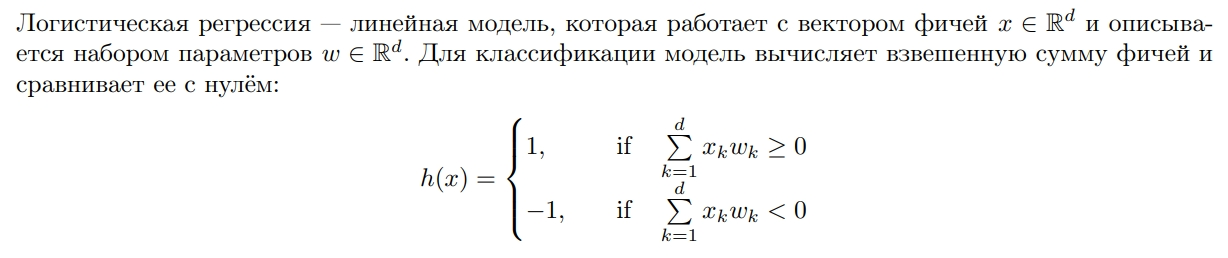![IMG_4.jpg](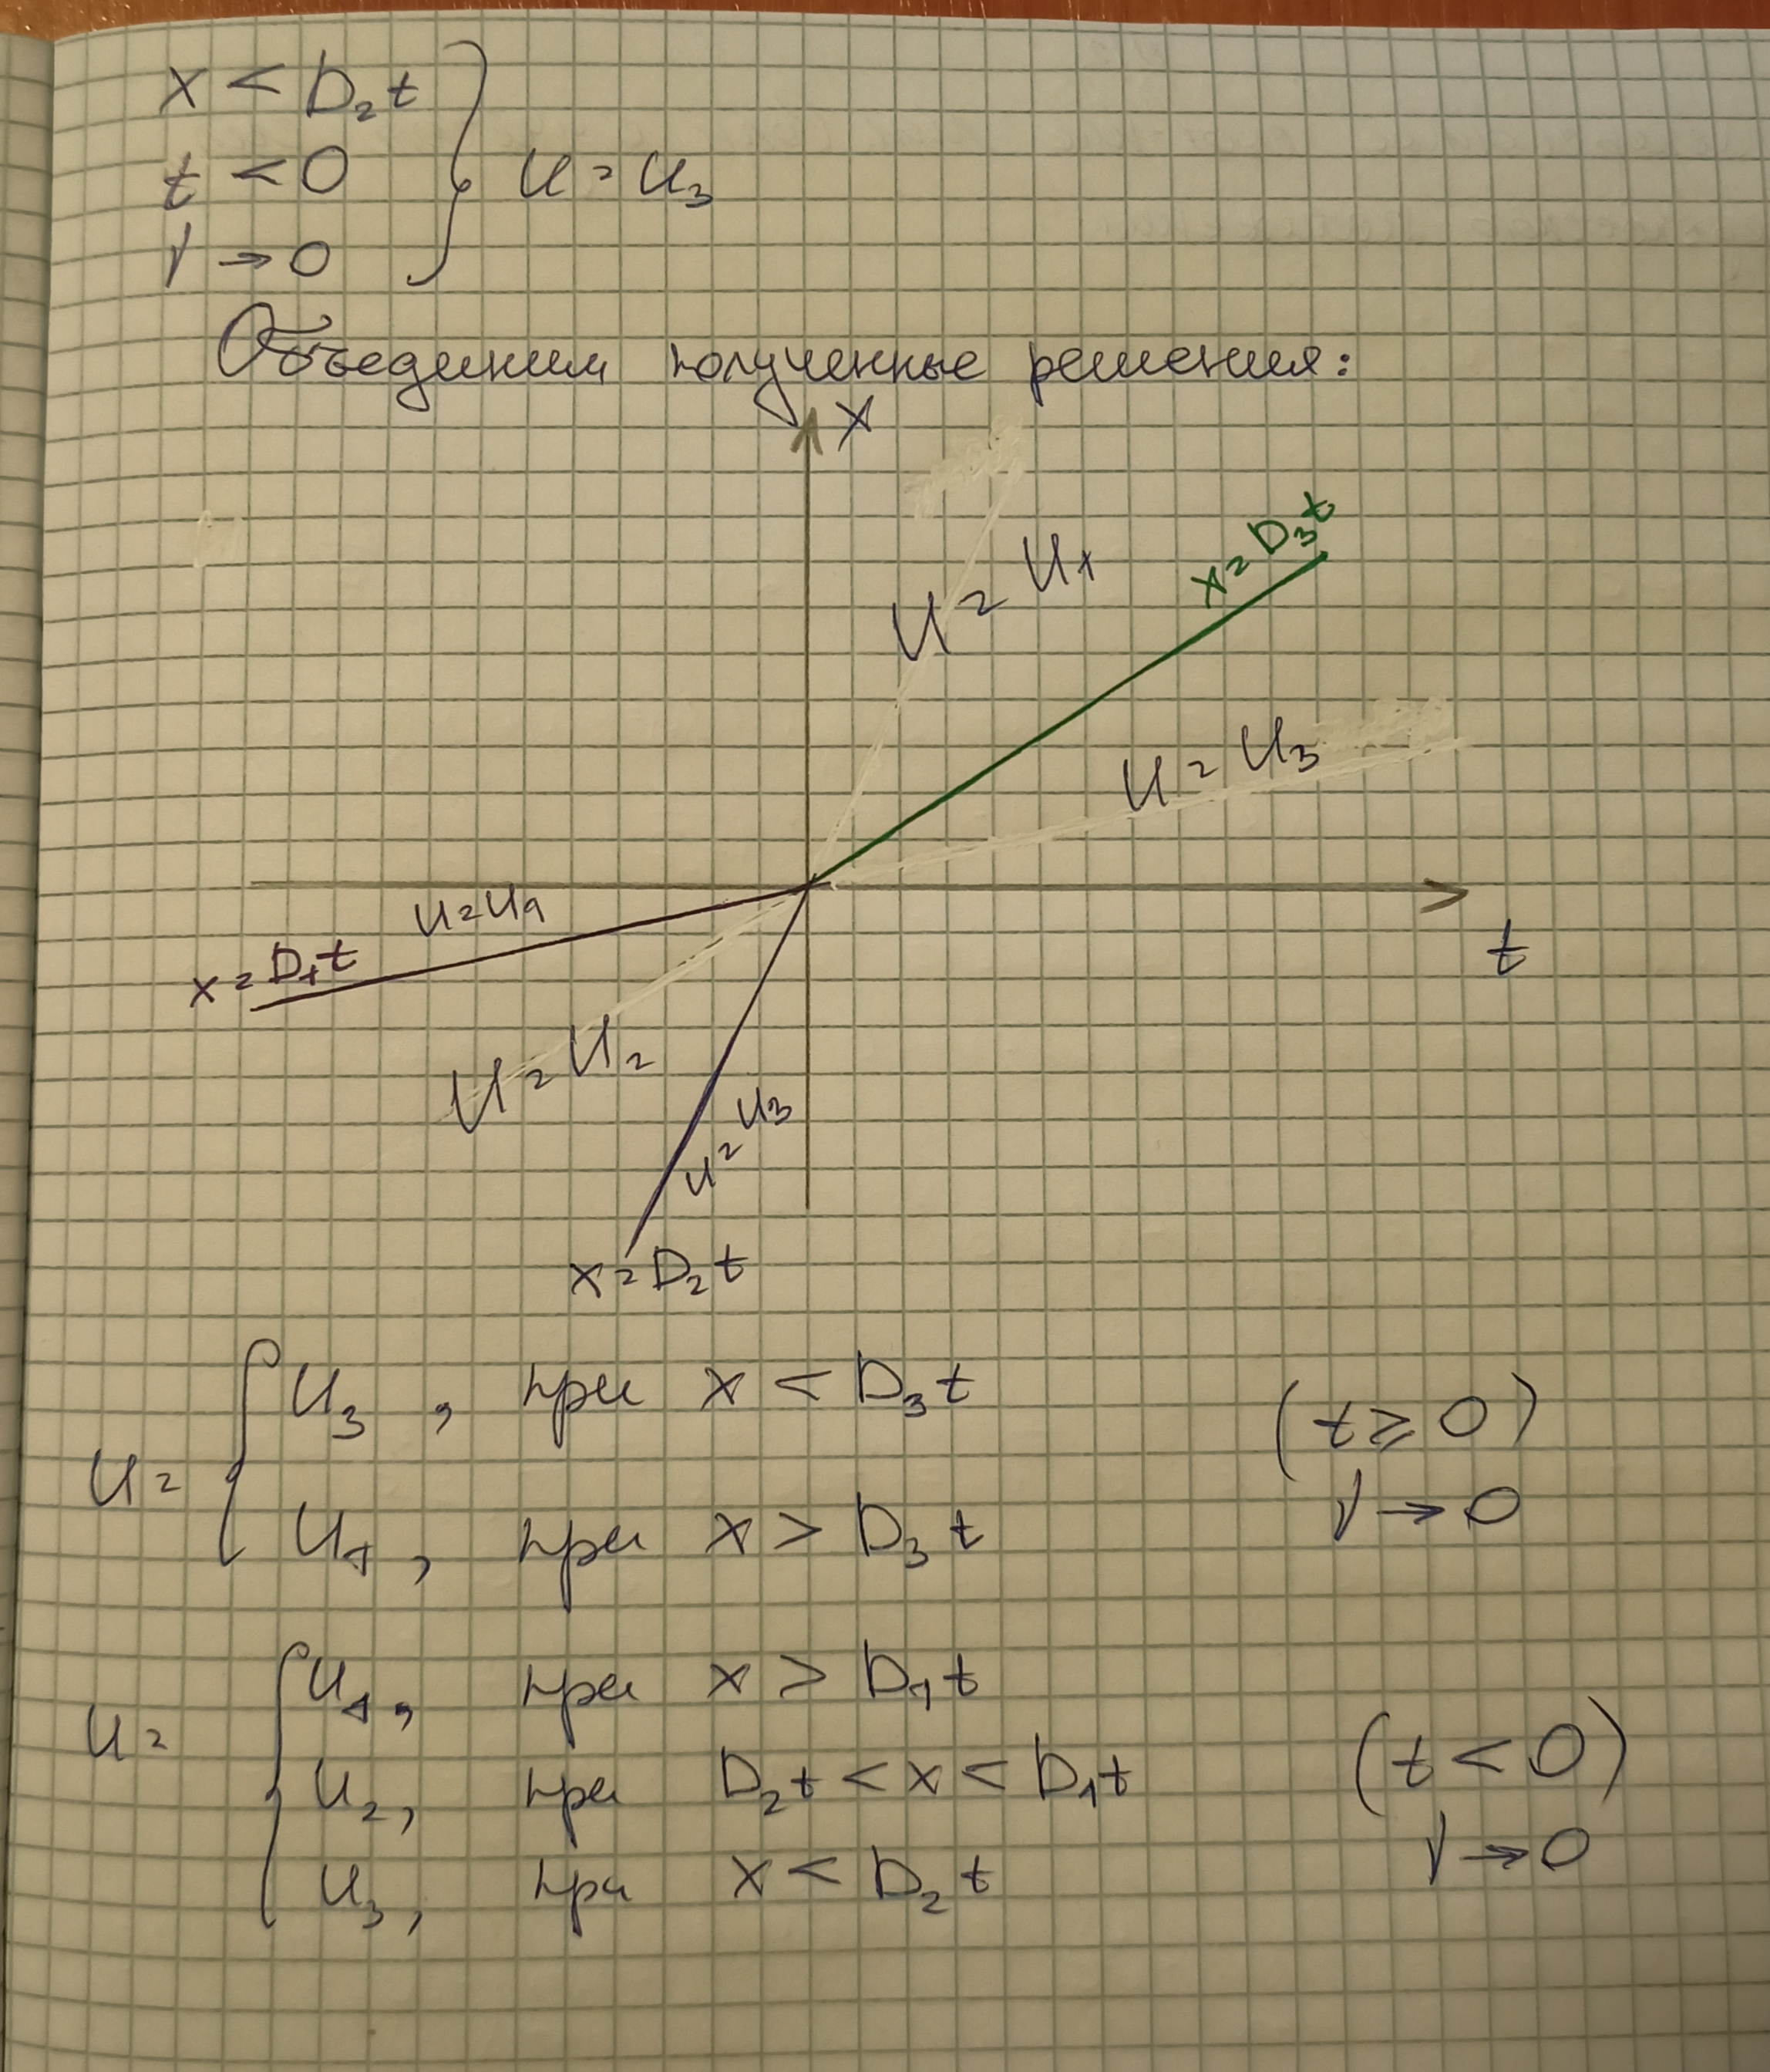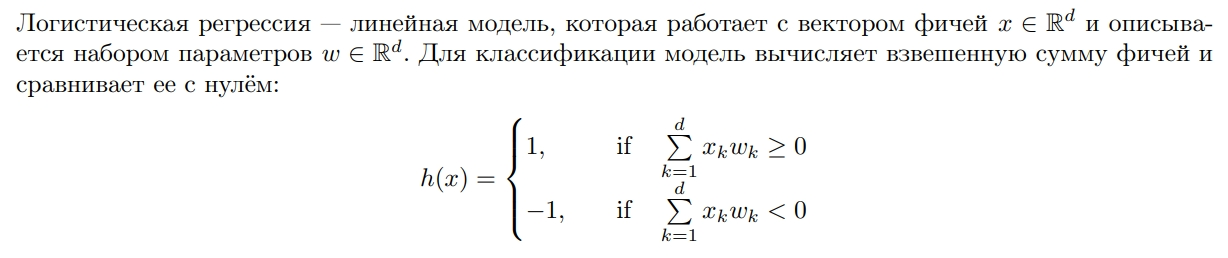))

MinMaxScaler во время .fit() для каждого признака $x_i$ считает минимум $x_{i, \text{min}}$ и максимум $x_{i, \text{max}}$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - x_{i, \text{min}}}{x_{i, \text{max}} - x_{i, \text{min}}}$$

Почему просто нельзя поделить на 255 весь обучающий датасет, ведь у нас 8-битные изображения?

In [ ]:
from sklearn.preprocessing import MinMaxScaler

tran = MinMaxScaler()
tran.fit(X_train)
# Выход numpy матрица, положим ее в новую переменную
X_train_normal = tran.transform(X_train)

#X_train = X_train/255
#print(X_train[0])

**Обучение**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train_normal, y_train)

In [ ]:
y_pred = logreg.predict(X_test)
print(f'Accuracy of logistic regression classifier on test set: {accuracy_score(y_pred, y_test)}')

In [ ]:
def print_metrics(y_preds, y_test):
    print(f'Accuracy of logistic regression classifier on test set: {accuracy_score(y_pred, y_test)}')

In [ ]:
print_metrics(y_pred, y_test)

Шаг 2. Атака незащищенной модели

Вычислимм значения оптимальной атаки $\delta^\star$ для каждого класса (-1 и 1)

\begin{equation}
\delta^\star = - y \cdot \epsilon \cdot \mathrm{sign}(w),
\end{equation}

In [ ]:
w = logreg.coef_
w.tolist
b = logreg.intercept_
#print(w)
#print(X_test.shape)
print(w.shape)
delta_minus = 0.2*np.sign(w)

image_delta_minus = delta_minus.reshape(28, 28)
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
axs.imshow(image_delta_minus)

print(delta_minus.size)
#print(delta_minus)

In [ ]:
delta_plus = -0.2*np.sign(w)

image_delta_plus = delta_plus.reshape(28, 28)
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
axs.imshow(image_delta_plus)


In [ ]:
tran = MinMaxScaler()
tran.fit(X_test)
X_test_normal = tran.transform(X_test)
print(X_test_normal.shape)

#Проатакуем
X_test_attack_1 = np.atleast_2d(delta_minus).repeat(repeats=2956, axis=0)
#np.repeat(delta_minus, repeats=X_test_normal.shape, axis=0)
X_test_attack_1 = X_test_normal + X_test_attack_1
#print(X_test_attack)

n = 5

fig, axs = plt.subplots(1, n, figsize=(8, 4))

for ax, image, label in zip(axs, X_test_attack_1[:n], y_test[:n]):

  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

In [ ]:
y_pred_attack_1 = logreg.predict(X_test_attack_1)
print(f'Accuracy of logistic regression classifier on test set: {accuracy_score(y_pred_attack_1, y_test)}')

In [ ]:
#Проатакуем
X_test_attack_2 = np.atleast_2d(delta_plus).repeat(repeats=2956, axis=0)
#np.repeat(delta_minus, repeats=X_test_normal.shape, axis=0)
X_test_attack_2 = X_test_normal + X_test_attack_2

n = 5

fig, axs = plt.subplots(1, n, figsize=(8, 4))

for ax, image, label in zip(axs, X_test_attack_2[:n], y_test[:n]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

In [ ]:
y_pred_attack_2 = logreg.predict(X_test_attack_2)
print(f'Accuracy of logistic regression classifier on test set: {accuracy_score(y_pred_attack_2, y_test)}')

Шаг 3. **Тренировка Robust Classifier**

\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_1 \right ).
\end{equation}

In [ ]:
def log_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred), axis=0 -0.2*abs()) / len(y_true)

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [21]:
def L_derivative(z):
  return -np.exp(-z)/(1 + np.exp(-z))

In [96]:
def Loss(X, y, e_1, e_2):
  Los = 0
  for i in range(len(X[:1])):
    Los = Los + np.log(1+np.exp(- y[i]*(X[i] @ (e_1).T + e_2)))
  return Los

In [107]:
X = X_test
y = y_test
w = np.random.randn(784)*0.001
b = np.random.randn()

L = Loss(X,y, w, b)
print(L)
L_w = np.zeros(784)
L_b = 0
for i in range(len(X[:1])):
  L_w = L_w + L_derivative(y[i]*(X[i] @ (w).T + b) - 0.2*np.linalg.norm(w, ord=1))*y[i]*w
  L_b = L_b + L_derivative(y[i]*(X[i] @ (w).T + b) - 0.2*np.linalg.norm(w, ord=1))*y[i]

  #Подсчёт новых значений параметров (шаг грдиентного спуска)
w = w - 0.05*L_w
b = b - 0.05*L_b

L = Loss(X,y, w, b)
print(L)

L_w = np.zeros(784)
L_b = 0
for i in range(len(X[:1])):
  L_w = L_w + L_derivative(y[i]*(X[i] @ (w).T + b) - 0.2*np.linalg.norm(w, ord=1))*y[i]*w
  L_b = L_b + L_derivative(y[i]*(X[i] @ (w).T + b) - 0.2*np.linalg.norm(w, ord=1))*y[i]

  #Подсчёт новых значений параметров (шаг грдиентного спуска)
w = w - 0.05*L_w
b = b - 0.05*L_b

L = Loss(X,y, w, b)
print(L)

L_w = np.zeros(784)
L_b = 0
for i in range(len(X[:1])):
  L_w = L_w + L_derivative(y[i]*(X[i] @ (w).T + b) - 0.2*np.linalg.norm(w, ord=1))*y[i]*w
  L_b = L_b + L_derivative(y[i]*(X[i] @ (w).T + b) - 0.2*np.linalg.norm(w, ord=1))*y[i]

  #Подсчёт новых значений параметров (шаг грдиентного спуска)
w = w - 0.05*L_w
b = b - 0.05*L_b

L = Loss(X,y, w, b)
print(L)


0.32473853412348225
0.31427778033704357
0.30426795716690447
0.2946881630743281


In [105]:
from sklearn.base import BaseEstimator

class RobustLogisticRegression(BaseEstimator):

    def __init__(self):
        super(RobustLogisticRegression, self).__init__()#Для инициализации унаследованных свойств вызываем метод инициализации родительского класса

        self.w = np.random.randn(784) #Веса модели (обучаемые параметры)
        self.b = np.random.randn() #Сдвиг линейной модели (обучаемые параметры)
        self.report_every = 40


    def fit(self, X, y, learning_rate=0.05, epochs=10):
        """Метод для тренировки модели по тренировочным данным X и y"""

        for epoch in range(epochs):

          #Найдём градиент Лосс функции по вектору w весов модели
          L_w = np.zeros(784)
          L_b = 0

          for i in range(len(X[:1])):
            L_w = L_w + L_derivative(y[i]*(X[i] @ (self.w).T + self.b) - 0.2*np.linalg.norm(self.w, ord=1))*y[i]*self.w
            L_b = L_b + L_derivative(y[i]*(X[i] @ (self.w).T + self.b) - 0.2*np.linalg.norm(self.w, ord=1))*y[i]

          print(L_w[1])
          #Подсчёт новых значений параметров (шаг грдиентного спуска)
          self.w = self.w - learning_rate*L_w
          self.b = self.b - learning_rate*L_b

          #print(self.w[1])
          L = Loss(X, y, self.w, self.b)
          #print(L)

          if epoch % self.report_every == 0:
            L = Loss(X, y, self.w, self.b)
            print(L)

    def predict(self, X):
        """Метод для предсказания классов для данных X"""
        y_pred = X @ (self.w).T + self.b

        if (y_pred >= 0):
          return 1
        else:
          return -1


In [104]:
rodlogreg = RobustLogisticRegression()
rodlogreg.fit(X_test, y_test)

-1.4402844963004921e-05
4.624214334081102e-09
-1.439893213604253e-05
-1.4395021433395017e-05
-1.4391112853333535e-05
-1.438720639413173e-05
-1.4383302054063467e-05
-1.4379399831406139e-05
-1.4375499724438803e-05
-1.4371601731441247e-05
-1.4367705850696202e-05
